## Spotify Genre Classification using Logistic Regression

This Jupyter notebook will use logistic regression to try and build a model to classify genres on spotify.

## Data Load

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")

## Exploratory Data Analysis

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [18]:
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [19]:
df['track_genre'].value_counts()

acoustic             1000
punk-rock            1000
progressive-house    1000
power-pop            1000
pop                  1000
                     ... 
folk                 1000
emo                  1000
electronic           1000
electro              1000
world-music          1000
Name: track_genre, Length: 114, dtype: int64

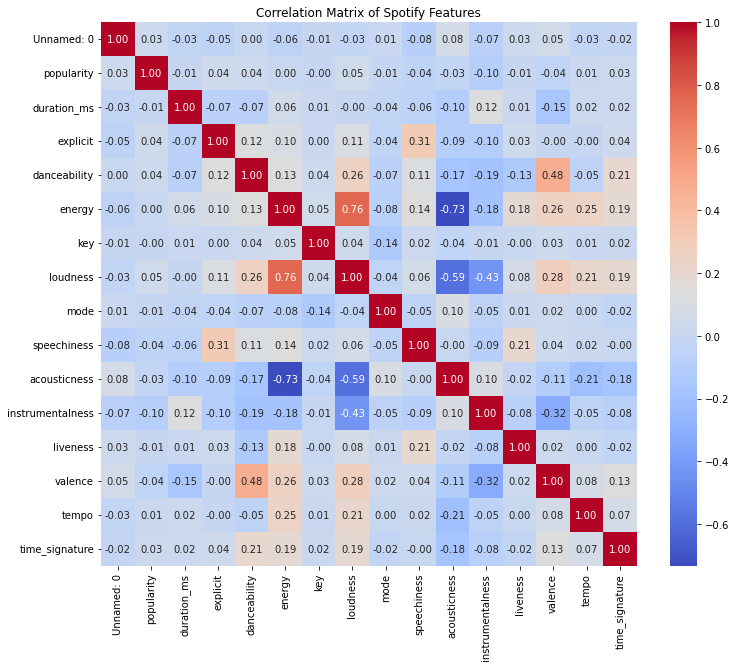

In [20]:
import seaborn as sns

# Compute the correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,  # Annotate each cell with its correlation value
    fmt=".2f",   # Format annotations to 2 decimal places
    cmap="coolwarm",  # Color scheme
    cbar=True
)
plt.title("Correlation Matrix of Spotify Features")
plt.show()

## Remove duplicates

The first thing we wanted to focus on after inspecting the structure of the data is removing duplicates. These are songs with the same track_id and track_name, but perhaps different genres. Duplicates can make it harder and more frustrating for the model to perform classification.

In [21]:
# Shuffle the dataset randomly to avoid any bias from alphabetical order
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Remove duplicates based on 'track_id' and 'track_name', keeping only the first occurrence
df_remove_duplicates = df_shuffled.drop_duplicates(subset=['track_id', 'track_name'], keep='first')

# Print the number of rows before and after removing duplicates
print(f"Original dataframe size: {len(df)}")
print(f"Cleaned dataframe size (duplicates removed): {len(df_remove_duplicates)}")

Original dataframe size: 114000
Cleaned dataframe size (duplicates removed): 89741


We moved about 21% of the rows for duplicates!

In [22]:
df_remove_duplicates.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,113186,6KwkVtXm8OUp2XffN5k7lY,Hillsong Worship,No Other Name,No Other Name,50,440247,False,0.369,0.598,...,-6.984,1,0.0304,0.00511,0.000000,0.176,0.0466,148.014,4,world-music
1,42819,2dp5I5MJ8bQQHDoFaNRFtX,Internal Rot,Grieving Birth,Failed Organum,11,93933,False,0.171,0.997,...,-3.586,1,0.1180,0.00521,0.801000,0.420,0.0294,122.223,4,grindcore
2,59311,5avw06usmFkFrPjX8NxC40,Zhoobin Askarieh;Ali Sasha,Noise A Noise 20.4-1,"Save the Trees, Pt. 1",0,213578,False,0.173,0.803,...,-10.071,0,0.1440,0.61300,0.001910,0.195,0.0887,75.564,3,iranian
3,91368,75hT0hvlESnDJstem0JgyR,Bryan Adams,All I Want For Christmas Is You,Merry Christmas,0,151387,False,0.683,0.511,...,-5.598,1,0.0279,0.40600,0.000197,0.111,0.5980,109.991,3,rock
4,61000,4bY2oZGA5Br3pTE1Jd1IfY,Nogizaka46,バレッタ TypeD,月の大きさ,57,236293,False,0.555,0.941,...,-3.294,0,0.0481,0.48400,0.000000,0.266,0.8130,92.487,4,j-idol


Features, like 'track_id' and 'track_name' are unique identifiers to the song and do not provide any meaninful information for prediction. Furthermore, features like 'artists' and 'album_name' introduce a large number of high-cardinality features, which will make the model unnecessarily complex.

In [23]:
# Now, we no longer need these variables
drop_columns = ['Unnamed: 0', 'track_id', 'artists', 'track_name', 'album_name']
df = df_remove_duplicates.drop(columns=drop_columns).reset_index(drop=True)

We also check for missing data.

In [24]:
# checking for missing values in dataset
print("Missing data: ", df.isnull().sum())

Missing data:  popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


## Feature Engineering

In [25]:
df.select_dtypes(exclude='number').head()

,explicit,track_genre
0,False,world-music
1,False,grindcore
2,False,iranian
3,False,rock
4,False,j-idol


In [26]:
df['explicit'].unique().tolist()

[False, True]

In [27]:
df['explicit'] = df['explicit'].astype(int)

In [28]:
df.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,50,440247,0,0.369,0.598,7,-6.984,1,0.0304,0.00511,0.000000,0.176,0.0466,148.014,4,world-music
1,11,93933,0,0.171,0.997,7,-3.586,1,0.1180,0.00521,0.801000,0.420,0.0294,122.223,4,grindcore
2,0,213578,0,0.173,0.803,9,-10.071,0,0.1440,0.61300,0.001910,0.195,0.0887,75.564,3,iranian
3,0,151387,0,0.683,0.511,6,-5.598,1,0.0279,0.40600,0.000197,0.111,0.5980,109.991,3,rock
4,57,236293,0,0.555,0.941,9,-3.294,0,0.0481,0.48400,0.000000,0.266,0.8130,92.487,4,j-idol


In [29]:
# check for imbalances
print(df['track_genre'].value_counts())

tango                999
study                998
sleep                997
idm                  995
comedy               994
                    ... 
edm                  412
singer-songwriter    388
songwriter           386
reggae               374
reggaeton            362
Name: track_genre, Length: 114, dtype: int64


In [30]:
df

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,50,440247,0,0.369,0.59800,7,-6.984,1,0.0304,0.00511,0.000000,0.1760,0.0466,148.014,4,world-music
1,11,93933,0,0.171,0.99700,7,-3.586,1,0.1180,0.00521,0.801000,0.4200,0.0294,122.223,4,grindcore
2,0,213578,0,0.173,0.80300,9,-10.071,0,0.1440,0.61300,0.001910,0.1950,0.0887,75.564,3,iranian
3,0,151387,0,0.683,0.51100,6,-5.598,1,0.0279,0.40600,0.000197,0.1110,0.5980,109.991,3,rock
4,57,236293,0,0.555,0.94100,9,-3.294,0,0.0481,0.48400,0.000000,0.2660,0.8130,92.487,4,j-idol
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89736,11,393160,0,0.733,0.87800,6,-8.960,0,0.0420,0.00355,0.887000,0.0984,0.6650,126.028,4,idm
89737,49,162613,0,0.554,0.00763,4,-30.566,1,0.0502,0.91500,0.000970,0.2210,0.1560,119.502,4,opera
89738,30,240062,0,0.689,0.55400,9,-8.200,1,0.0759,0.09100,0.914000,0.0867,0.1630,148.002,4,trance
89739,44,216841,0,0.421,0.10700,6,-15.191,1,0.0335,0.94800,0.000000,0.0881,0.1180,104.218,4,acoustic


In [31]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['track_genre_encoded'] = le.fit_transform(df['track_genre'])

In [32]:
genre_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(genre_mapping)

{'acoustic': 0, 'afrobeat': 1, 'alt-rock': 2, 'alternative': 3, 'ambient': 4, 'anime': 5, 'black-metal': 6, 'bluegrass': 7, 'blues': 8, 'brazil': 9, 'breakbeat': 10, 'british': 11, 'cantopop': 12, 'chicago-house': 13, 'children': 14, 'chill': 15, 'classical': 16, 'club': 17, 'comedy': 18, 'country': 19, 'dance': 20, 'dancehall': 21, 'death-metal': 22, 'deep-house': 23, 'detroit-techno': 24, 'disco': 25, 'disney': 26, 'drum-and-bass': 27, 'dub': 28, 'dubstep': 29, 'edm': 30, 'electro': 31, 'electronic': 32, 'emo': 33, 'folk': 34, 'forro': 35, 'french': 36, 'funk': 37, 'garage': 38, 'german': 39, 'gospel': 40, 'goth': 41, 'grindcore': 42, 'groove': 43, 'grunge': 44, 'guitar': 45, 'happy': 46, 'hard-rock': 47, 'hardcore': 48, 'hardstyle': 49, 'heavy-metal': 50, 'hip-hop': 51, 'honky-tonk': 52, 'house': 53, 'idm': 54, 'indian': 55, 'indie': 56, 'indie-pop': 57, 'industrial': 58, 'iranian': 59, 'j-dance': 60, 'j-idol': 61, 'j-pop': 62, 'j-rock': 63, 'jazz': 64, 'k-pop': 65, 'kids': 66, 'lat

## Model  1 Training and Evaluation

First, we are going to try a baseline model with all genres and all features included.

In [33]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['track_genre', 'track_genre_encoded'])  # Assuming you dropped original `track_genre`
y = df['track_genre_encoded']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [34]:
# Initialize Logistic Regression model
model = LogisticRegression(multi_class='multinomial', max_iter=500)

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate model performance
print(f'Classification Report:\n{classification_report(y_test, y_pred)}')

Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.13      0.13       196
           1       0.24      0.18      0.20       186
           2       0.00      0.00      0.00        93
           3       0.07      0.01      0.02        86
           4       0.31      0.36      0.33       172
           5       0.07      0.02      0.04       165
           6       0.45      0.53      0.49       189
           7       0.29      0.27      0.28       173
           8       0.11      0.01      0.02       117
           9       0.14      0.02      0.03       132
          10       0.26      0.20      0.23       204
          11       0.14      0.01      0.01       136
          12       0.12      0.15      0.13       178
          13       0.30      0.44      0.36       190
          14       0.24      0.46      0.32       182
          15       0.17      0.15      0.16       175
          16       0.44      0.42      0.43       156
    

/Users/emilysu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilysu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilysu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We get an accuracy of 25%. This is not that good.

## Feature Importance

Let's try figuring out feature importance to see which features contribute more. We are able to compare coefficients because we scaled our data at the beginning.

In [35]:
# Extract feature importance (coefficients)
coefficients = model.coef_  # Shape: (n_classes, n_features)

# Map coefficients to feature names
feature_names = X.columns  # Assuming the columns of X are the feature names
feature_names

Index(['popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature'],
      dtype='object')

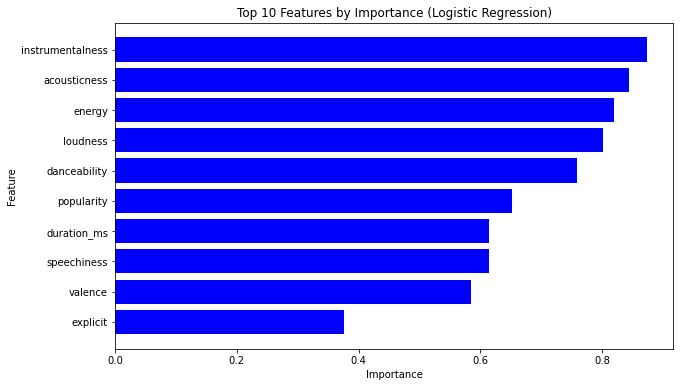

             Feature  Importance
10  instrumentalness    0.873216
9       acousticness    0.843838
4             energy    0.820231
6           loudness    0.801342
3       danceability    0.759318
0         popularity    0.652090
1        duration_ms    0.614713
8        speechiness    0.614356
12           valence    0.585129
2           explicit    0.376663
7               mode    0.184933
11          liveness    0.173199
13             tempo    0.168375
14    time_signature    0.134904
5                key    0.052687


In [36]:
import numpy as np

# For multi-class logistic regression, we can average absolute coefficients across classes
# Take the mean of absolute coefficients across all classes
avg_importance = np.mean(np.abs(coefficients), axis=0)

# Create a DataFrame for interpretability
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_importance
})

# Sort by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Visualize the top 10 features by importance
top_features = feature_importance.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='blue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features by Importance (Logistic Regression)')
plt.gca().invert_yaxis()
plt.show()

# Optional: Print the sorted feature importance table
print(feature_importance)

Let's consider only retaining features with a feature important of above 0.6.

## Model 2 Training and Evaluation

Next, we try using feature importance and only consider the top features from our feature importance.

In [37]:
from sklearn.metrics import classification_report, accuracy_score

# List of features to retain
selected_features = [
    "instrumentalness",
    "acousticness",
    "energy",
    "loudness",
    "danceability",
    "popularity",
    "duration_ms",
    "speechiness",
]

# Filter the dataframe to include only the selected features and the target
X = df[selected_features]
y = df["track_genre_encoded"]  # Replace "track_genre" with the actual target column name

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression model
logreg = LogisticRegression(max_iter=1000, solver='liblinear')
logreg.fit(X_train_scaled, y_train)

# Make predictions
y_pred = logreg.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.2077

Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.18      0.17       180
           1       0.28      0.04      0.07       194
           2       0.00      0.00      0.00        88
           3       0.00      0.00      0.00        88
           4       0.27      0.33      0.30       169
           5       0.02      0.01      0.01       158
           6       0.35      0.41      0.37       187
           7       0.18      0.14      0.16       197
           8       0.00      0.00      0.00       122
           9       0.00      0.00      0.00       116
          10       0.21      0.15      0.17       193
          11       0.00      0.00      0.00       154
          12       0.09      0.12      0.10       187
          13       0.33      0.44      0.38       195
          14       0.19      0.30      0.23       196
          15       0.12      0.09      0.10       159
          16       0.40      0.32      0

/Users/emilysu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilysu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilysu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The accuracy actually dropped to 22%. Now, let's consider if we only track the top 50 genres and the top features.

In [38]:
# Step 1: Identify the top 50 genres by frequency
top_genres = df["track_genre"].value_counts().head(40).index

# Step 2: Filter the dataframe to include only rows with top genres
df_top_genres = df[df["track_genre"].isin(top_genres)]

# Step 3: Update features and target
X = df_top_genres[selected_features]  # Retain the selected features
y = df_top_genres["track_genre_encoded"]      # Update target to filtered genres

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

logreg_40 = LogisticRegression(max_iter=1000, solver='liblinear')
logreg_40.fit(X_train_scaled, y_train)

# Make predictions
y_pred = logreg_40.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with Top 50 Genres: {accuracy:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy with Top 50 Genres: 0.4051

Classification Report:
              precision    recall  f1-score   support

           1       0.28      0.04      0.06       194
           6       0.60      0.45      0.51       187
           7       0.30      0.17      0.21       196
          10       0.33      0.22      0.26       193
          12       0.26      0.16      0.20       187
          13       0.42      0.43      0.42       195
          14       0.40      0.43      0.42       196
          17       0.39      0.12      0.19       197
          18       0.70      0.81      0.75       199
          19       0.24      0.32      0.27       182
          24       0.43      0.58      0.50       194
          26       0.44      0.15      0.23       188
          27       0.37      0.36      0.37       190
          35       0.42      0.56      0.48       187
          36       0.25      0.09      0.13       184
          42       0.70      0.86      0.78       198
          45       0.

The accuracy improved to 40%. This is still not great, but an improvement from our previous models.

## Regularization

Finally, let's try regularization.

In [39]:
logreg_reg = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, solver='liblinear')
logreg_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred = logreg_reg.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with Top 50 Genres and Regularization: {accuracy:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy with Top 50 Genres and Regularization: 0.4051

Classification Report:
              precision    recall  f1-score   support

           1       0.28      0.04      0.06       194
           6       0.60      0.45      0.51       187
           7       0.30      0.17      0.21       196
          10       0.33      0.22      0.26       193
          12       0.26      0.16      0.20       187
          13       0.42      0.43      0.42       195
          14       0.40      0.43      0.42       196
          17       0.39      0.12      0.19       197
          18       0.70      0.81      0.75       199
          19       0.24      0.32      0.27       182
          24       0.43      0.58      0.50       194
          26       0.44      0.15      0.23       188
          27       0.37      0.36      0.37       190
          35       0.42      0.56      0.48       187
          36       0.25      0.09      0.13       184
          42       0.70      0.86      0.78       198
  

Regularization doesn't seem to change anything.

In [41]:
from sklearn.model_selection import cross_val_score

# Step 1: Identify the top 50 genres by frequency
top_genres = df["track_genre"].value_counts().head(40).index

# Step 2: Filter the dataframe to include only rows with top genres
df_top_genres = df[df["track_genre"].isin(top_genres)]

# Step 3: Update features and target
X = df_top_genres[selected_features]  # Retain the selected features
y = df_top_genres["track_genre_encoded"]      # Update target to filtered genres

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

logreg_40 = LogisticRegression(max_iter=1000, solver='liblinear')

# Perform 5-fold cross-validation
cv_scores = cross_val_score(logreg_40, X_scaled, y, cv=5, scoring='accuracy')  # Change scoring as needed

# Print the cross-validation scores
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.4f}")

Cross-validation scores: [0.40289364 0.40028676 0.39707991 0.39655847 0.39473341]
Mean cross-validation score: 0.3983
